# <u>Projet 7: "Implémentez un modèle de scoring" - Modélisation<u>

In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import gc
import warnings
warnings.filterwarnings('ignore')

# <u>I. Prétraitement

## <u>I.1 Prétraitement des données

In [2]:
data = pd.read_csv('clean_data.csv')
data.head()

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,Age,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,RATIO_ANNUITY_CREDIT,RATIO_INCOME_CREDIT,RATIO_INCOME_ANNUITY,RATIO_AGE_WORK_DAYS
0,0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,25.920548,637.0,3648.0,2120,1,0,1,0,Laborers,2,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,2.0,2.0,2.0,2.0,1134.0,0.060749,0.498036,8.198215,24.575098
1,2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,52.180822,225.0,4260.0,2531,1,1,1,0,Laborers,2,9,0,0,0,0,0,0,Government,0.555912,0.729567,0.0,0.0,0.0,0.0,815.0,0.050000,0.500000,10.000000,4.311929
2,5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,0.035792,46.413699,1588.0,4970.0,477,1,1,1,0,Laborers,2,16,0,0,0,0,0,0,Other,0.354225,0.621226,0.0,0.0,0.0,0.0,2536.0,0.056101,0.201837,3.597711,34.214037
3,6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.035792,37.747945,3130.0,1213.0,619,1,0,1,0,Accountants,2,16,0,0,0,0,0,0,Business Entity Type 3,0.724000,0.492060,1.0,0.0,1.0,0.0,1562.0,0.026463,0.109564,4.140336,82.918421
4,7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.003122,51.643836,449.0,4597.0,2379,1,1,0,0,Managers,3,16,0,0,0,0,1,1,Other,0.714279,0.540654,2.0,0.0,2.0,0.0,1070.0,0.027500,0.235294,8.556150,8.694164


In [3]:
data = data.drop('Unnamed: 0', axis=1)
data = data.set_index('SK_ID_CURR')

In [4]:
data.shape

(244852, 44)

In [5]:
data.dropna().shape

(244852, 44)

Il ne manque aucune valeur.

In [6]:
data.dtypes

TARGET                           int64
NAME_CONTRACT_TYPE              object
CODE_GENDER                     object
FLAG_OWN_CAR                    object
FLAG_OWN_REALTY                 object
CNT_CHILDREN                     int64
AMT_INCOME_TOTAL               float64
AMT_CREDIT                     float64
AMT_ANNUITY                    float64
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_FAMILY_STATUS              object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE     float64
Age                            float64
DAYS_EMPLOYED                  float64
DAYS_REGISTRATION              float64
DAYS_ID_PUBLISH                  int64
FLAG_EMP_PHONE                   int64
FLAG_WORK_PHONE                  int64
FLAG_PHONE                       int64
FLAG_EMAIL                       int64
OCCUPATION_TYPE                 object
REGION_RATING_CLIENT_W_CITY      int64
HOUR_APPR_PROCESS_START  

In [7]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

nums_feats = make_column_selector(dtype_include=np.number)
categs_feats = make_column_selector(dtype_exclude=np.number)

numerical_pipeline_ss = make_pipeline(StandardScaler())
numerical_pipeline_mms = make_pipeline(MinMaxScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'))

prepro_ss  = make_column_transformer((numerical_pipeline_ss, nums_feats), (categorical_pipeline, categs_feats))
prepro_mms  = make_column_transformer((numerical_pipeline_mms, nums_feats), (categorical_pipeline, categs_feats))

In [8]:
X = data.drop('TARGET', axis=1)
Y = data['TARGET']

## <u>II.2 Métrique d'évaluation

Nous utiliserons l'aire sous la courbe ROC afin de déterminer l'efficacité de notre classifieur.

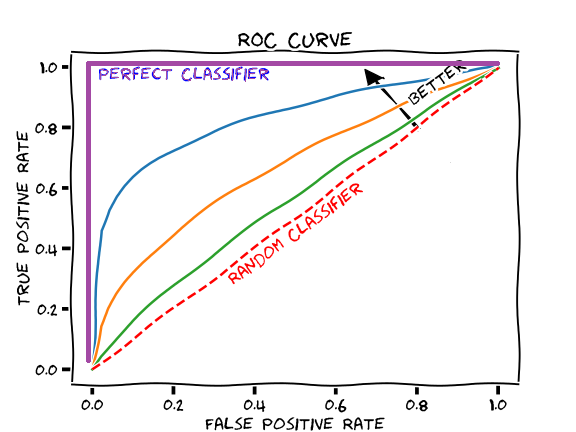

# <u>II. Baseline: Régression logistique

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)

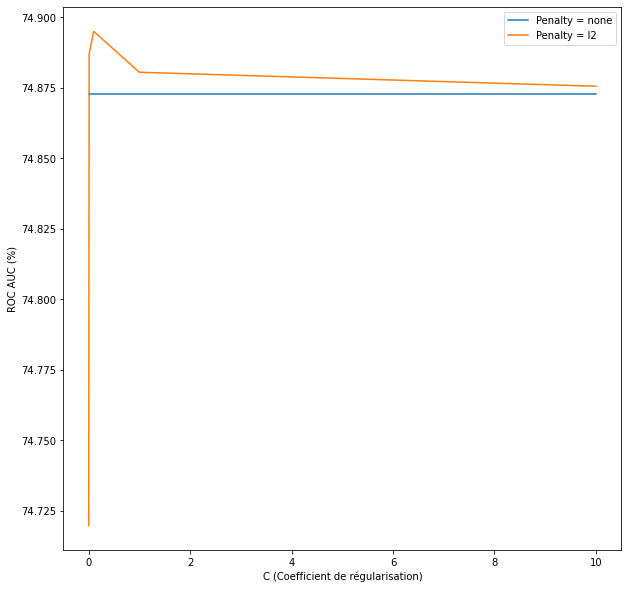

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

plt.figure(figsize=(10,10))

for penalty in ['none', 'l2']:
    
    log_reg = LogisticRegression(penalty=penalty)
    log_reg_model = make_pipeline(prepro_ss, log_reg)
    params = {'logisticregression__C': np.logspace(-3, 1, 5)}
    grid = GridSearchCV(log_reg_model, param_grid=params, cv=4, scoring = 'roc_auc')
    grid.fit(X_train, Y_train)
    
    x = list(grid.cv_results_['param_logisticregression__C'])
    scores = 100*grid.cv_results_['mean_test_score']
    plt.plot(x, scores, label= f'Penalty = {penalty}')

plt.ylabel('ROC AUC (%)')
plt.xlabel('C (Coefficient de régularisation)')
plt.legend()
plt.show()

In [11]:
log_reg = LogisticRegression(C=0.1)
log_reg_model = make_pipeline(prepro_ss, log_reg)
log_reg_model.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017CE046BBE0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017CE046BD00>)])),
                ('logisticregression', LogisticRegression(C=0.1))])

In [12]:
Y_predicted = log_reg_model.predict(X_test)
Y_predicted_prob = log_reg_model.predict_proba(X_test)[:, 1]

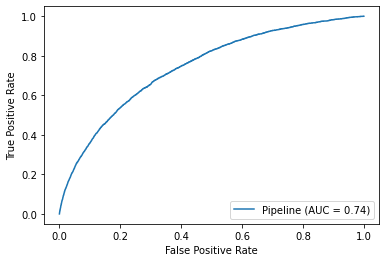

In [13]:
from sklearn import metrics 
metrics.plot_roc_curve(log_reg_model, X_test, Y_test)
plt.show()

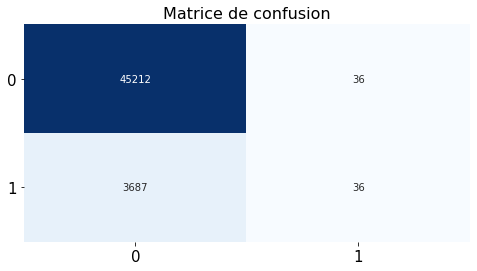

In [14]:
## Plot Matrice de confusion
    
cm = metrics.confusion_matrix(Y_test, Y_predicted)

plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.title("Matrice de confusion", size=16)
plt.yticks(rotation=0, size=15)
plt.xticks(rotation=0, size=15)
plt.show()


In [2]:
def prediction_results(X_test, Y_test, model):
    
    Y_predicted = model.predict(X_test)
    Y_predicted_prob = model.predict_proba(X_test)[:, 1]

    metrics.plot_roc_curve(model, X_test, Y_test)
    plt.show()
    
    cm = metrics.confusion_matrix(Y_test, Y_predicted)

    plt.figure(figsize=(8,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
    plt.title("Matrice de confusion", size=16)
    plt.yticks(rotation=0, size=15)
    plt.xticks(rotation=0, size=15)
    plt.show()
    
    print('Accuracy', metrics.accuracy_score(Y_test, Y_predicted))

On constate que moins d'1% des difficultés de paiements ont été détectées. Ce n'est pas un bon modèle.

Il faudrait essayer d'avoir autant d'individus ayant pour target 0 que d'individus ayant pour target 1.

In [16]:
data_2 = pd.concat([data[data['TARGET']==1],data[data['TARGET']==0].sample(20000)])

In [17]:
X = data_2.drop('TARGET', axis=1)
Y = data_2['TARGET']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
log_reg = LogisticRegression(C=0.1)
log_reg_model = make_pipeline(prepro_ss, log_reg)
log_reg_model.fit(X_train, Y_train)

Y_predicted = log_reg_model.predict(X_test)
Y_predicted_prob = log_reg_model.predict_proba(X_test)[:, 1]

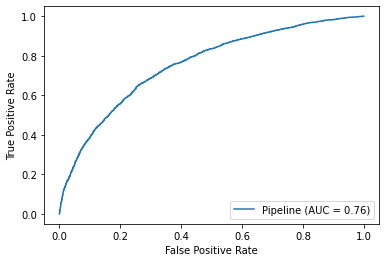

In [18]:
metrics.plot_roc_curve(log_reg_model, X_test, Y_test)
plt.show()

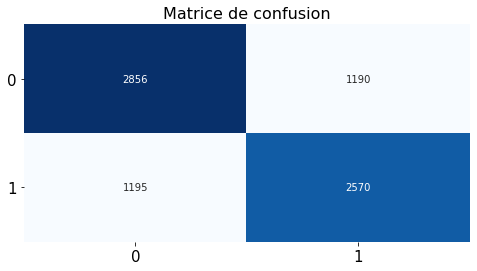

In [19]:
cm = metrics.confusion_matrix(Y_test, Y_predicted)

plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.title("Matrice de confusion", size=16)
plt.yticks(rotation=0, size=15)
plt.xticks(rotation=0, size=15)
plt.show()

Le résultat semble bien plus concret. Essayons sur les données de test précédentes.

In [20]:
X = data.drop('TARGET', axis=1)
Y = data['TARGET']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
Y_predicted = log_reg_model.predict(X_test)
Y_predicted_prob = log_reg_model.predict_proba(X_test)[:, 1]

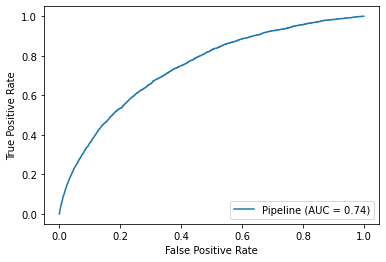

In [21]:
metrics.plot_roc_curve(log_reg_model, X_test, Y_test)
plt.show()

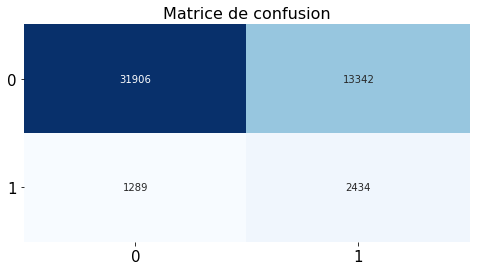

In [22]:
cm = metrics.confusion_matrix(Y_test, Y_predicted)

plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.title("Matrice de confusion", size=16)
plt.yticks(rotation=0, size=15)
plt.xticks(rotation=0, size=15)
plt.show()

print()

Les prédictions semblent toujours assez correctes.

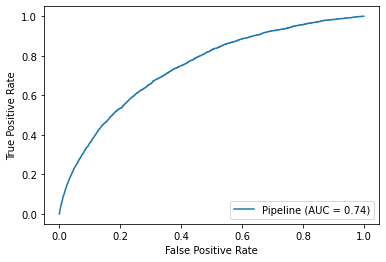

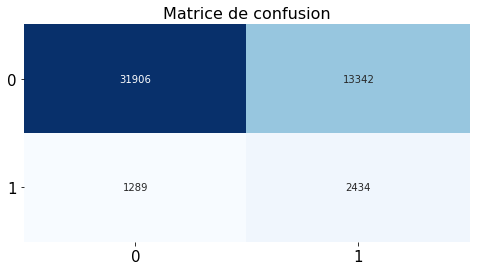

Accuracy 0.7012313409977333


In [23]:
prediction_results(X_test, Y_test, log_reg_model)

# <u>III. Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

X = data_2.drop('TARGET', axis=1)
Y = data_2['TARGET']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
rf = RandomForestClassifier(random_state=0)
rf_model = make_pipeline(prepro_ss, rf)
rf_model.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017CE046BBE0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017CE046BD00>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

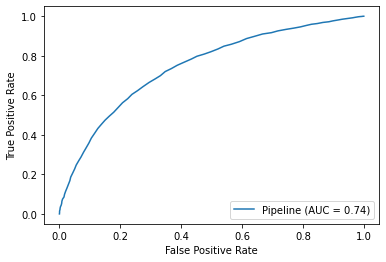

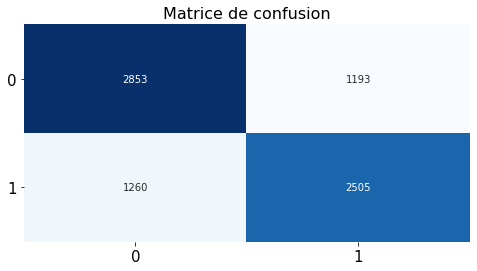

Accuracy 0.6859557034950711


In [25]:
prediction_results(X_test, Y_test, rf_model)

Le random Forest non-optimisé est un peu moins bon que la régression logistique.

In [3]:
def importance_features(pipeline_model):
    
    '''Retourne le dictionnaire des importances de chaque variables après entrainement d'un modèle
    basé sur des arbres de décision.
    Pour les variables trasformées par OneHotEncoding, les valeurs d'importances sont sommées et
    regroupées dans 'importance de la variable d'origine. Cette fonction vise principalement
    à automatiser ce processus complexe'''
    
    feats_importance = pipeline_model.steps[1][1].feature_importances_
    
    onehot_feats = rf_model.named_steps['columntransformer'].named_transformers_['pipeline-2']\
    .named_steps['onehotencoder'].get_feature_names()
    
    count_feats_dict = {}

    for i, col in enumerate(X_train.select_dtypes('object').columns):
        count_feats_dict[col]=0
        for feat in onehot_feats:
            if int(feat[1]) == i:
                count_feats_dict[col]+=1
    
    feats_importance_dict = {}

    for i, key in enumerate(list(X_train.select_dtypes(exclude='object').columns)):
        feats_importance_dict[key] = feats_importance[i]

    for key in list(count_feats_dict.keys()):
        feats_importance_dict[key] = 0

    n_num_feats = len(X_train.select_dtypes(exclude='object').columns)
    cat_number = 0
    n = list(count_feats_dict.values())[cat_number] + n_num_feats

    for i in range(n_num_feats, len(feats_importance)):
        if i < n + list(count_feats_dict.values())[cat_number]:
            key = list(count_feats_dict.keys())[cat_number]
            feats_importance_dict[key] += feats_importance[i]
        else:
            cat_number+=1
            n += list(count_feats_dict.values())[cat_number]
            key = list(count_feats_dict.keys())[cat_number]
            feats_importance_dict[key] += feats_importance[i]
            
    plt.figure(figsize=(10,20))
    pd.Series(feats_importance_dict).sort_values().plot(kind='barh', color = 'b')
    plt.show()

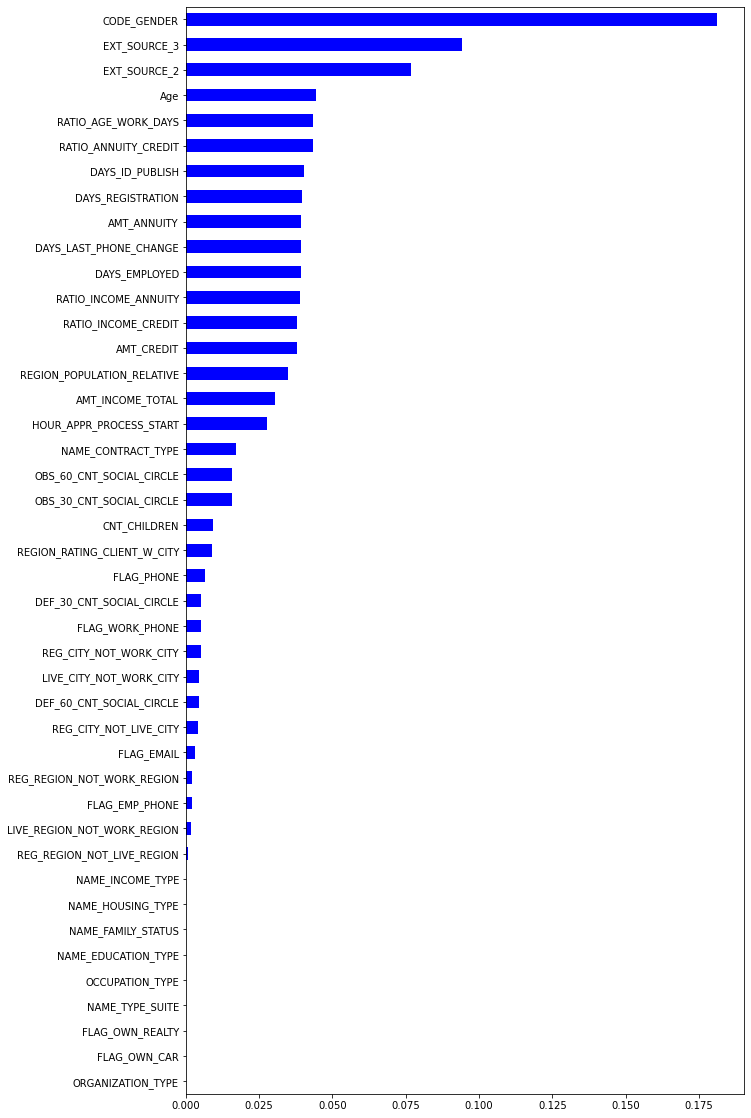

In [27]:
importance_features(rf_model)

**optimisation**

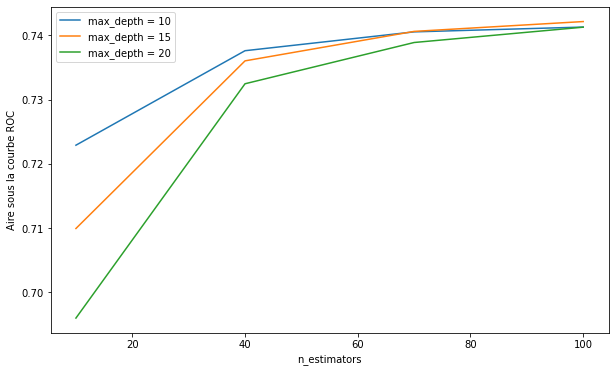

In [28]:
plt.figure(figsize=(10,6))

for k in [10, 15, 20]:
    rf = RandomForestClassifier(random_state=0, max_depth=k)
    rf_model = make_pipeline(prepro_ss, rf)

    params = {'randomforestclassifier__n_estimators': np.arange(10, 130, 30)}
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
    grid = GridSearchCV(rf_model, param_grid=params, cv=4, scoring = 'roc_auc')
    grid.fit(X_train, Y_train)
    
    x = list(grid.cv_results_['param_randomforestclassifier__n_estimators'])
    scores = grid.cv_results_['mean_test_score']
    plt.plot(x, scores, label= f'max_depth = {k}')
        
plt.ylabel('Aire sous la courbe ROC')
plt.xlabel('n_estimators')
plt.legend()
plt.show()

On choisira une max_depth de 15 minimum et n_estimators au moins égal à 80

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] randomforestclassifier__min_samples_split=2 .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... randomforestclassifier__min_samples_split=2, total=  10.5s
[CV] randomforestclassifier__min_samples_split=2 .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s


[CV] ...... randomforestclassifier__min_samples_split=2, total=  10.7s
[CV] randomforestclassifier__min_samples_split=2 .....................
[CV] ...... randomforestclassifier__min_samples_split=2, total=   3.6s
[CV] randomforestclassifier__min_samples_split=2 .....................
[CV] ...... randomforestclassifier__min_samples_split=2, total=   3.4s
[CV] randomforestclassifier__min_samples_split=3 .....................
[CV] ...... randomforestclassifier__min_samples_split=3, total=  10.4s
[CV] randomforestclassifier__min_samples_split=3 .....................
[CV] ...... randomforestclassifier__min_samples_split=3, total=  10.6s
[CV] randomforestclassifier__min_samples_split=3 .....................
[CV] ...... randomforestclassifier__min_samples_split=3, total=   3.4s
[CV] randomforestclassifier__min_samples_split=3 .....................
[CV] ...... randomforestclassifier__min_samples_split=3, total=   3.6s
[CV] randomforestclassifier__min_samples_split=4 .....................
[CV] .

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  3.8min finished


Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] randomforestclassifier__min_samples_split=2 .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... randomforestclassifier__min_samples_split=2, total=  22.6s
[CV] randomforestclassifier__min_samples_split=2 .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.5s remaining:    0.0s


[CV] ...... randomforestclassifier__min_samples_split=2, total=  22.7s
[CV] randomforestclassifier__min_samples_split=2 .....................
[CV] ...... randomforestclassifier__min_samples_split=2, total=   4.4s
[CV] randomforestclassifier__min_samples_split=2 .....................
[CV] ...... randomforestclassifier__min_samples_split=2, total=   4.5s
[CV] randomforestclassifier__min_samples_split=3 .....................
[CV] ...... randomforestclassifier__min_samples_split=3, total=  22.2s
[CV] randomforestclassifier__min_samples_split=3 .....................
[CV] ...... randomforestclassifier__min_samples_split=3, total=  27.0s
[CV] randomforestclassifier__min_samples_split=3 .....................
[CV] ...... randomforestclassifier__min_samples_split=3, total=   7.8s
[CV] randomforestclassifier__min_samples_split=3 .....................
[CV] ...... randomforestclassifier__min_samples_split=3, total=   5.8s
[CV] randomforestclassifier__min_samples_split=4 .....................
[CV] .

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  7.3min finished


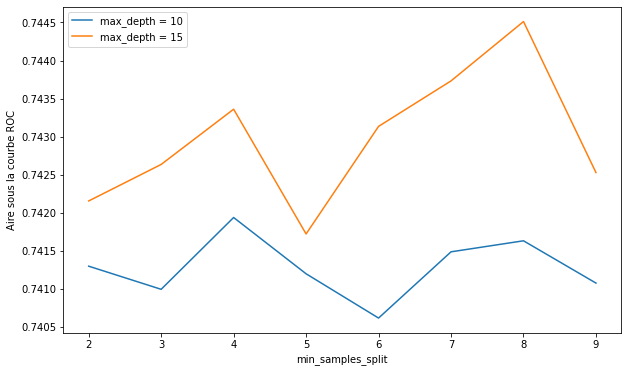

In [29]:
plt.figure(figsize=(10,6))

for k in [10, 15]:
    rf = RandomForestClassifier(random_state=0, max_depth=k)
    rf_model = make_pipeline(prepro_ss, rf)

    params = {'randomforestclassifier__min_samples_split': np.arange(2, 10)}
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
    grid = GridSearchCV(rf_model, param_grid=params, cv=4, scoring = 'roc_auc')
    grid.fit(X_train, Y_train)
    
    x = list(grid.cv_results_['param_randomforestclassifier__min_samples_split'])
    scores = grid.cv_results_['mean_test_score']
    plt.plot(x, scores, label= f'max_depth = {k}')
        
plt.ylabel('Aire sous la courbe ROC')
plt.xlabel('min_samples_split')
plt.legend()
plt.show()

Random forest est très lent, nous ne l'utiliserons pas.
LightBGM est un modèle de boosting très rapide et adapaté aux datasets de grande dimension.

# <u>IV. Light Gradient Boosting

In [30]:
from lightgbm import LGBMClassifier

## 1. Essai sur les données réduites

In [31]:
lgb = LGBMClassifier(random_state=0)
lgb_model = make_pipeline(prepro_ss, lgb)

In [32]:
lgb_model.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017CE046BBE0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017CE046BD00>)])),
                ('lgbmclassifier', LGBMClassifier(random_state=0))])

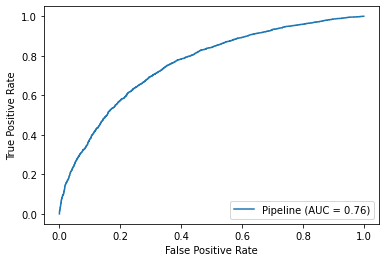

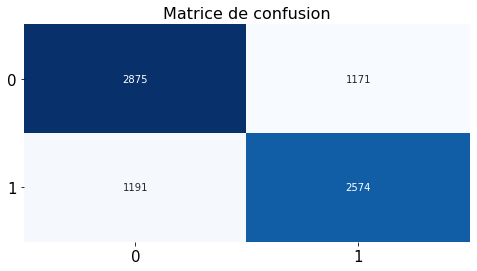

Accuracy 0.6976059403405453


In [33]:
prediction_results(X_test, Y_test, lgb_model)

**Optimisation**

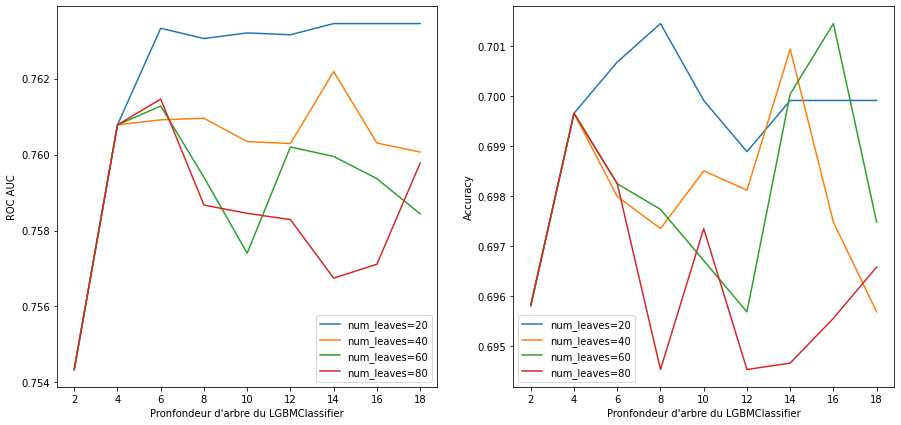

In [34]:
fig, ax = plt.subplots(1,2,figsize=(15, 7))

for i in np.arange(20, 100, 20):
    x, y1, y2 = [], [], []
    for k in np.arange(2, 20, 2):
        
        lgb = LGBMClassifier(random_state=0, max_depth=k, num_leaves=i)
        lgb_model = make_pipeline(prepro_ss, lgb)
        lgb_model.fit(X_train, Y_train)

        y_pred = lgb_model.predict(X_test)
        auc = metrics.roc_auc_score(Y_test, lgb_model.predict_proba(X_test)[:, 1])
        accuracy = metrics.accuracy_score(Y_test, y_pred)
        y1.append(auc)
        y2.append(accuracy)
        x.append(k)
    
    ax[0].plot(x, y1, label=f'num_leaves={i}')
    ax[1].plot(x, y2, label=f'num_leaves={i}')
    
    ax[0].set_xlabel("Pronfondeur d'arbre du LGBMClassifier")   
    ax[0].set_ylabel("ROC AUC")   
    ax[0].legend()
    ax[1].set_xlabel("Pronfondeur d'arbre du LGBMClassifier")   
    ax[1].set_ylabel("Accuracy")   
    ax[1].legend()
    
plt.show()

Nous choisirons max_depth=12 et num_leaves=20

In [35]:
lgb = LGBMClassifier(random_state=0, num_leaves=20, max_depth=12)
lgb_model = make_pipeline(prepro_ss, lgb)

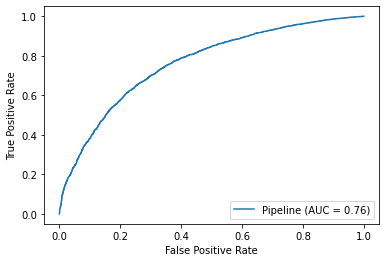

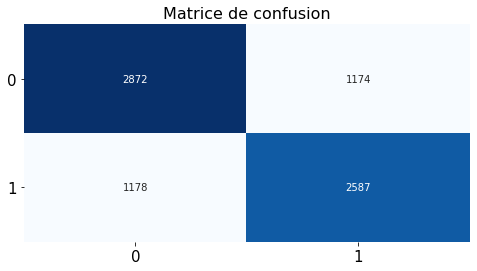

Accuracy 0.6988861861477403


In [36]:
lgb_model.fit(X_train, Y_train)
prediction_results(X_test, Y_test, lgb_model)

Nous avons finalement assez peu optimisé le modèle.

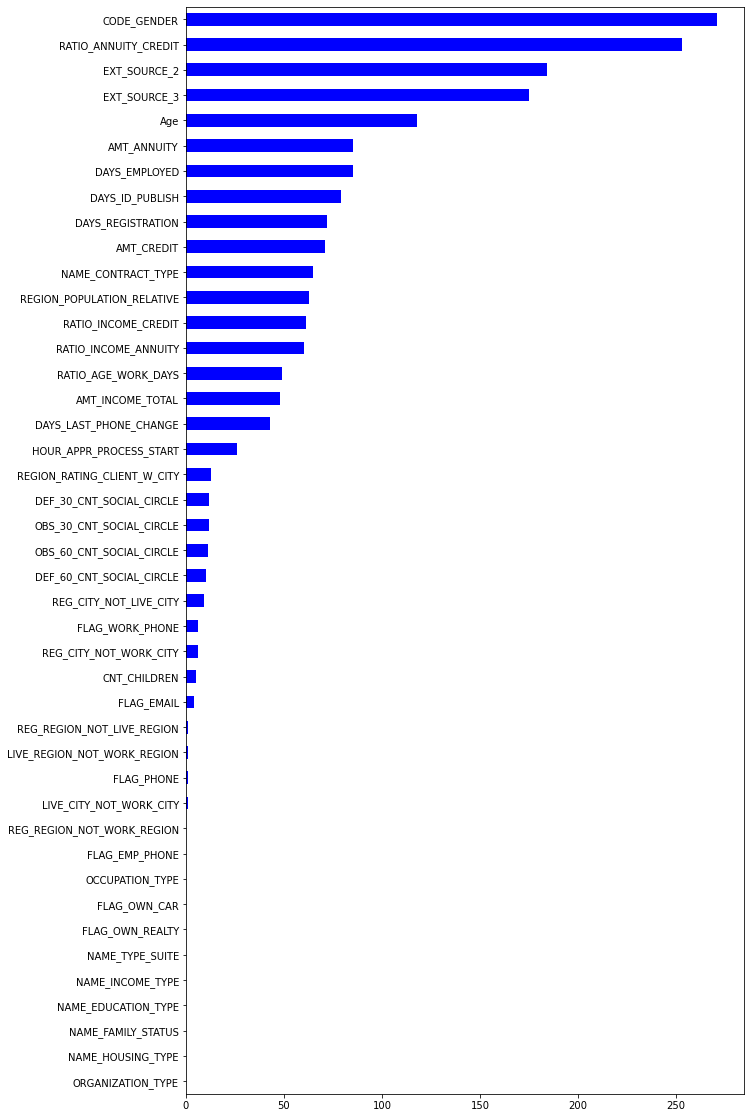

In [37]:
importance_features(lgb_model)

**essai avec le preprocessing min_maxscaler**

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


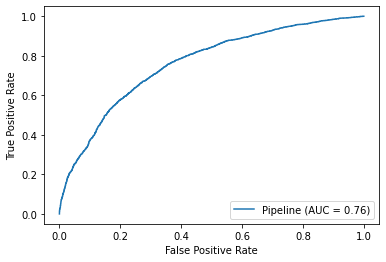

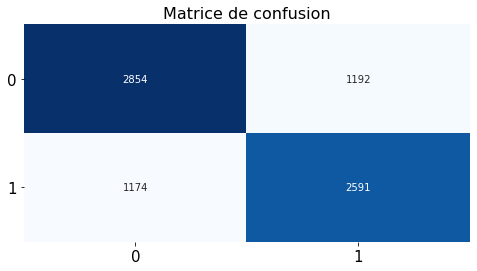

Accuracy 0.6970938420176674


In [38]:
lgb = LGBMClassifier(random_state=0, max_depth=12)
lgb_model = make_pipeline(prepro_mms, lgb)
lgb_model.fit(X_train, Y_train)
prediction_results(X_test, Y_test, lgb_model)

Les résultats sont similaires.

## 2. Essai sur les données complètes

In [116]:
full_data = pd.read_csv('full_data.csv')
full_data = full_data.set_index('SK_ID_CURR')
full_data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,Age,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,RATIO_ANNUITY_CREDIT,RATIO_INCOME_CREDIT,RATIO_INCOME_ANNUITY,RATIO_AGE_WORK_DAYS,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,ca__Active,ca__Bad debt,ca__Closed,ca__Sold,cu__currency 1,cu__currency 2,cu__currency 3,cu__currency 4,ty__Another type of loan,ty__Car loan,ty__Cash loan (non-earmarked),ty__Consumer credit,ty__Credit card,ty__Interbank credit,ty__Loan for business development,ty__Loan for purchase of shares (margin lending),ty__Loan for the purchase of equipment,ty__Loan for working capital replenishment,ty__Microloan,ty__Mobile operator loan,ty__Mortgage,ty__Real estate loan,ty__Unknown type of loan,SK_ID_PREV_x,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT_y,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START_y,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FLAG_LAST_APPL_PER_CONTRACT_N,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CASH_LOAN_PURPOSE_Building a house or an annex,NAME_CASH_LOAN_PURPOSE_Business development,NAME_CASH_LOAN_PURPOSE_Buying a garage,NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land,NAME_CASH_LOAN_PURPOSE_Buying a home,NAME_CASH_LOAN_PURPOSE_Buying a new car,NAME_CASH_LOAN_PURPOSE_Buying a used car,NAME_CASH_LOAN_PURPOSE_Car repairs,NAME_CASH_LOAN_PURPOSE_Education,NAME_CASH_LOAN_PURPOSE_Everyday expenses,NAME_CASH_LOAN_PURPOSE_Furniture,NAME_CASH_LOAN_PURPOSE_Gasification / water supply,NAME_CASH_LOAN_PURPOSE_Hobby,NAME_CASH_LOAN_PURPOSE_Journey,NAME_CASH_LOAN_PURPOSE_Medicine,NAME_CASH_LOAN_PURPOSE_Money for a third person,NAME_CASH_LOAN_PURPOSE_Other,NAME_CASH_LOAN_PURPOSE_Payments on other loans,NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment,NAME_CASH_LOAN_PURPOSE_Refusal to name the goal,NAME_CASH_LOAN_PURPOSE_Repairs,NAME_CASH_LOAN_PURPOSE_Urgent needs,NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday,NAME_CASH_LOAN_PURPOSE_XAP,NAME_CASH_LOAN_PURPOSE_XNA,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_R

In [40]:
full_data.shape

(142655, 263)

In [41]:
full_data.TARGET.value_counts()

0    131990
1     10665
Name: TARGET, dtype: int64

Equilibrage des target

In [42]:
full_data = pd.concat([full_data[full_data['TARGET']==1],full_data[full_data['TARGET']==0].sample(10665)])

In [43]:
X = full_data.drop('TARGET', axis=1)
Y = full_data['TARGET']

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0, shuffle=True)

In [45]:
import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [46]:
float_columns = X_train.select_dtypes('float64').columns

In [47]:
ss = StandardScaler()
X_train[float_columns] = ss.fit_transform(X_train[float_columns])
X_test[float_columns] = ss.transform(X_test[float_columns])
X_train

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,Age,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,RATIO_ANNUITY_CREDIT,RATIO_INCOME_CREDIT,RATIO_INCOME_ANNUITY,RATIO_AGE_WORK_DAYS,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,ca__Active,ca__Baddebt,ca__Closed,ca__Sold,cu__currency1,cu__currency2,cu__currency3,cu__currency4,ty__Anothertypeofloan,ty__Carloan,ty__Cashloannonearmarked,ty__Consumercredit,ty__Creditcard,ty__Interbankcredit,ty__Loanforbusinessdevelopment,ty__Loanforpurchaseofsharesmarginlending,ty__Loanforthepurchaseofequipment,ty__Loanforworkingcapitalreplenishment,ty__Microloan,ty__Mobileoperatorloan,ty__Mortgage,ty__Realestateloan,ty__Unknowntypeofloan,SK_ID_PREV_x,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT_y,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START_y,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Consumerloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_CONTRACT_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FLAG_LAST_APPL_PER_CONTRACT_N,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CASH_LOAN_PURPOSE_Buildingahouseoranannex,NAME_CASH_LOAN_PURPOSE_Businessdevelopment,NAME_CASH_LOAN_PURPOSE_Buyingagarage,NAME_CASH_LOAN_PURPOSE_Buyingaholidayhomeland,NAME_CASH_LOAN_PURPOSE_Buyingahome,NAME_CASH_LOAN_PURPOSE_Buyinganewcar,NAME_CASH_LOAN_PURPOSE_Buyingausedcar,NAME_CASH_LOAN_PURPOSE_Carrepairs,NAME_CASH_LOAN_PURPOSE_Education,NAME_CASH_LOAN_PURPOSE_Everydayexpenses,NAME_CASH_LOAN_PURPOSE_Furniture,NAME_CASH_LOAN_PURPOSE_Gasificationwatersupply,NAME_CASH_LOAN_PURPOSE_Hobby,NAME_CASH_LOAN_PURPOSE_Journey,NAME_CASH_LOAN_PURPOSE_Medicine,NAME_CASH_LOAN_PURPOSE_Moneyforathirdperson,NAME_CASH_LOAN_PURPOSE_Other,NAME_CASH_LOAN_PURPOSE_Paymentsonotherloans,NAME_CASH_LOAN_PURPOSE_Purchaseofelectronicequipment,NAME_CASH_LOAN_PURPOSE_Refusaltonamethegoal,NAME_CASH_LOAN_PURPOSE_Repairs,NAME_CASH_LOAN_PURPOSE_Urgentneeds,NAME_CASH_LOAN_PURPOSE_Weddinggiftholiday,NAME_CASH_LOAN_PURPOSE_XAP,NAME_CASH_LOAN_PURPOSE_XNA,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unusedoffer,NAME_PAYMENT_TYPE_Cashthroughthebank,NAME_PAYMENT_TYPE_Cashlessfromtheaccountoftheemployer,NAME_PAYMENT_TYPE_Noncashfromyouraccount,NAME_PAYMENT_TYPE_XNA,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_GOODS_CATEGORY_AdditionalService,NAME_GOODS_CATEGOR

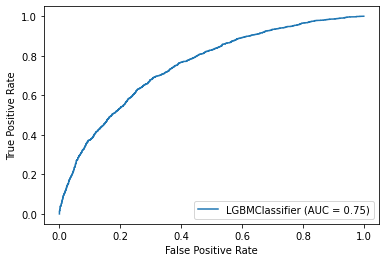

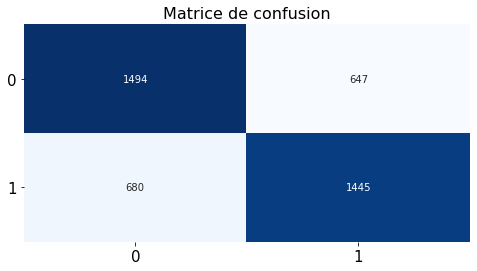

Accuracy 0.6889357712142522


In [48]:
lgb = LGBMClassifier(random_state=0)
lgb.fit(X_train, Y_train)
prediction_results(X_test, Y_test, lgb)

**Optimisation**

# <u>V. Explication des prédictions

## <u> V.I Essai avec Lime

## 1. Essai sur les données réduites

In [49]:
X = data_2.drop('TARGET', axis=1)
Y = data_2['TARGET']
X = pd.get_dummies(X)

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)

In [51]:
ss = StandardScaler()
X_train[X_train.columns] = ss.fit_transform(X_train[X_train.columns])
X_train

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,Age,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,RATIO_ANNUITY_CREDIT,RATIO_INCOME_CREDIT,RATIO_INCOME_ANNUITY,RATIO_AGE_WORK_DAYS,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_unknown,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4

In [52]:
X_test[X_test.columns] = ss.transform(X_test[X_test.columns])
X_test

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,Age,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,RATIO_ANNUITY_CREDIT,RATIO_INCOME_CREDIT,RATIO_INCOME_ANNUITY,RATIO_AGE_WORK_DAYS,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_unknown,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4

In [53]:
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

lgb = LGBMClassifier(random_state=0, num_leaves=20, max_depth=12)
lgb.fit(X_train, Y_train)

LGBMClassifier(max_depth=12, num_leaves=20, random_state=0)

In [160]:
import lime

from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Pas de dificultés', 'Difficultés'],
    mode='classification'
)

In [165]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[7], 
    predict_fn=lgb.predict_proba
)

exp.show_in_notebook(show_table=True)

ValueError: cannot convert float NaN to integer

Le principal problème est que cela ne focntionne pas lorsqu'il y a des valeurs manquantes.

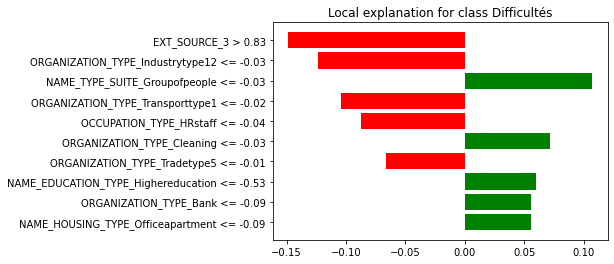

In [56]:
fig = exp.as_pyplot_figure()
plt.show()

## <u> V.II Essai avec Shap

**Essai sans standard scaling et sans les EXT_SOURCES**

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import re
from lightgbm import LGBMClassifier

In [4]:
full_data = pd.read_csv('full_data.csv')
full_data = full_data.set_index('SK_ID_CURR')

full_data = pd.concat([full_data[full_data['TARGET']==1],full_data[full_data['TARGET']==0].sample(24812, random_state=0)])
full_data = full_data.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)

X = full_data.drop('TARGET', axis=1)
Y = full_data['TARGET']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)

X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [5]:
lgb = LGBMClassifier(random_state=0)
lgb.fit(X_train, Y_train)

LGBMClassifier(random_state=0)

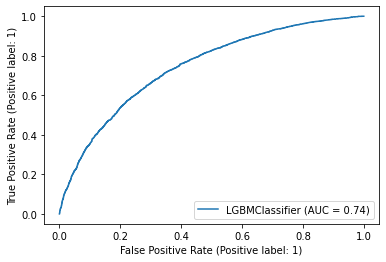

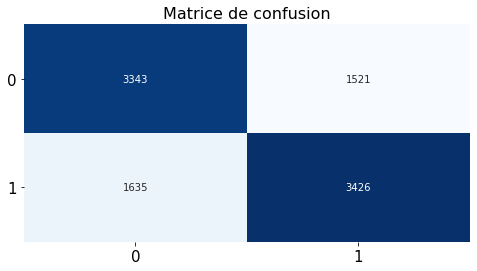

Accuracy 0.682015113350126


In [6]:
prediction_results(X_test, Y_test, lgb)

Nous appliquons le modèle sur le jeu de données complet

In [6]:
full_data = pd.read_csv('full_data.csv')
full_data = full_data.set_index('SK_ID_CURR')

full_data = full_data.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)

X = full_data.drop('TARGET', axis=1)
Y = full_data['TARGET']

In [7]:
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [8]:
gc.collect()

42

In [10]:
score_table = pd.DataFrame(Y)
score_table['SCORE'] = lgb.predict_proba(X)[:,0]
score_table.head()

,TARGET,SCORE
SK_ID_CURR,,
100002,1,0.199183
100003,0,0.913490
100004,0,0.664483
100006,0,0.762409
100007,0,0.650411


In [12]:
score_table.head(10000).to_csv('score_table.csv')

In [13]:
X = X.head(5000)
X.to_csv('X_5000.csv')

In [14]:
import shap

explainer = shap.TreeExplainer(lgb)
shap_values = explainer.shap_values(X)

In [15]:
shap_values[0].shape

(5000, 381)

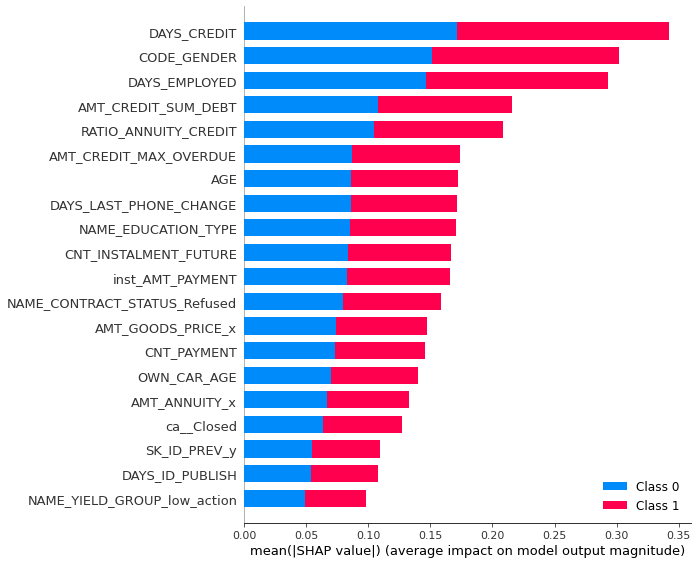

In [16]:
shap.summary_plot(shap_values, X)

In [22]:
shap.initjs()
sk_id = 100006
shap.force_plot(explainer.expected_value[0], shap_values[1][0,:], X.loc[sk_id])

In [78]:
X

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,AGE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,RATIO_AGE_WORK_DAYS,RATIO_INCOME_ANNUITY,RATIO_INCOME_CREDIT,RATIO_ANNUITY_CREDIT,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,ca__Active,ca__Baddebt,ca__Closed,ca__Sold,cu__currency1,cu__currency2,cu__currency3,cu__currency4,ty__Anothertypeofloan,ty__Carloan,ty__Cashloannonearmarked,ty__Consumercredit,ty__Creditcard,ty__Interbankcredit,ty__Loanforbusinessdevelopment,ty__Loanforpurchaseofsharesmarginlending,ty__Loanforthepurchaseofequipment,ty__Loanforworkingcapitalreplenishment,ty__Microloan,ty__Mobileoperatorloan,ty__Mortgage,ty__Realestateloan,ty__Unknowntypeofloan,avg_buro_MONTHS_BALANCE,avg_buro_bureau_status_0,avg_buro_bureau_status_1,avg_buro_bureau_status_2,avg_buro_bureau_status_3,avg_buro_bureau_status_4,avg_buro_bureau_status_5,avg_buro_bureau_status_C,avg_buro_bureau_status_X,avg_buro_buro_count,SK_ID_PREV_x,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT_y,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE_y,HOUR_APPR_PROCESS_START_y,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Consumerloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_CONTRACT_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FLAG_LAST_APPL_PER_CONTRACT_N,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CASH_LOAN_PURPOSE_Buildingahouse

In [79]:
X.reset_index().index[X.reset_index().SK_ID_CURR == 105849][0]

4995

Ce graphique est peu explicatif des données.

Afin de transformer (remettre à la bonne échelle) les shap values, il est nécessaire d'effectuer quelques opérations.
Le code suivant est inspiré du topic disponible ici. https://github.com/slundberg/shap/issues/29

In [48]:
from scipy.special import expit 

def shap_rescale(shap_values, expected_value, model_prediction):  
    
    expected_value_transformed = expit(expected_value)
    original_explanation_distance = sum(shap_values)
    distance_to_explain = model_prediction - expected_value_transformed
    distance_coefficient = original_explanation_distance / distance_to_explain
    shap_values_transformed = shap_values / distance_coefficient
    
    return shap_values_transformed, expected_value_transformed

In [59]:
shap_values=explainer.shap_values(X)[1][0]
expected_value=explainer.expected_value[1]
model_prediction=lgb.predict_proba(X)[:,1][0]

shap_values_trans = shap_rescale(shap_values, expected_value, model_prediction)[0]
expected_value_trans = shap_rescale(shap_values, expected_value, model_prediction)[1]

In [101]:
shap_values_trans

(381,)

In [60]:
lgb.predict_proba(X)[:,1][0]

0.8008165148702375

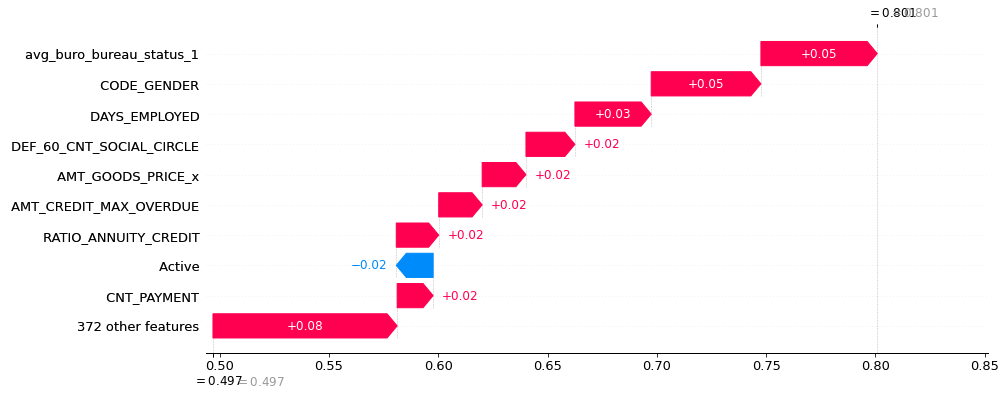

In [61]:
shap.plots._waterfall.waterfall_legacy(expected_value_trans,
                                       shap_values_trans,
                                       X.values.reshape(-1),
                                       feature_names=X.columns,
                                       max_display=15, show=False)
plt.gcf().set_size_inches((10,10))
plt.show()

In [107]:
def waterfall(sk_id, n_feats=10):
    
    row = X.reset_index().index[X.reset_index().SK_ID_CURR == sk_id][0]

    shap_values=explainer.shap_values(X)[1][row]
    expected_value=explainer.expected_value[1]
    model_prediction=lgb.predict_proba(X)[:,1][row]

    shap_values_trans = shap_rescale(shap_values, expected_value, model_prediction)[0]
    expected_value_trans = shap_rescale(shap_values, expected_value, model_prediction)[1]
    
    fig = shap.plots._waterfall.waterfall_legacy(0.5,#expected_value_trans,
                                       shap_values_trans,
                                       #X.values.reshape(-1),
                                       feature_names=X.columns,
                                       max_display=n_feats, show=False)
    fig = plt.gcf().set_size_inches((10,10))
    plt.title(f'Top {n_feats} des variables les plus influentes sur le prêt n°{sk_id}', size=20)
    
    return fig

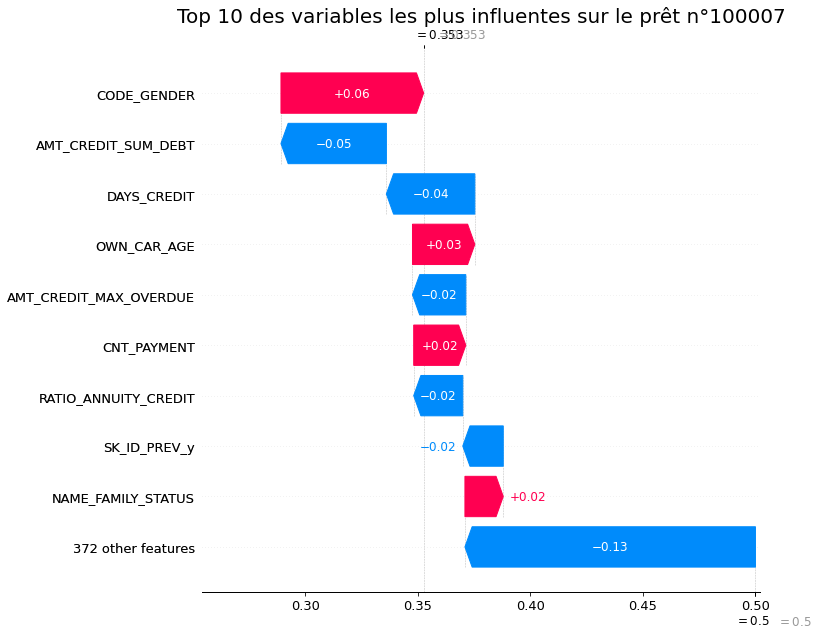

In [108]:
waterfall(100007)

Il serait utile d'implementer cette focntion a partir des shap values et expected values déjà transformées.
Cela permettrait au dashboard de charger moins de données.

In [127]:
def transform_shap(sk_id):
    row = X.reset_index().index[X.reset_index().SK_ID_CURR == sk_id][0]

    shap_values=explainer.shap_values(X)[1][row]
    expected_value=explainer.expected_value[1]
    model_prediction=lgb.predict_proba(X)[:,1][row]

    shap_values_trans = shap_rescale(shap_values, expected_value, model_prediction)[0]
    
    return shap_values_trans

In [128]:
shap_data = pd.DataFrame(X.columns).rename(columns={0:'Feature'}).set_index('Feature')

In [130]:
%time
for sk_id in X.index[:1000]:
    shap_data[str(sk_id)] = transform_shap(sk_id)
    print(sk_id)

Wall time: 0 ns
100002
100003
100004
100006
100007
100008
100009
100010
100011
100012
100014
100015
100016
100017
100018
100019
100020
100021
100022
100023
100024
100025
100026
100027
100029
100030
100031
100032
100033
100034
100035
100036
100037
100039
100040
100041
100043
100044
100045
100046
100047
100048
100049
100050
100051
100052
100053
100054
100055
100056
100058
100059
100060
100061
100062
100063
100064
100068
100069
100070
100071
100072
100073
100075
100076
100077
100078
100079
100080
100081
100082
100083
100084
100085
100086
100087
100088
100089
100093
100094
100095
100096
100097
100098
100099
100100
100101
100102
100103
100104
100105
100108
100110
100111
100112
100113
100114
100115
100116
100118
100119
100120
100121
100122
100123
100124
100125
100126
100127
100129
100130
100131
100132
100133
100134
100135
100136
100137
100138
100139
100140
100142
100143
100144
100145
100146
100147
100148
100149
100151
100152
100153
100154
100155
100156
100157
100158
100159
100160
100161
1001

In [134]:
shap_data.to_csv('shap_data_1000.csv')

In [136]:
pd.read_csv('shap_data_1000.csv').set_index('Feature')

100002    100003    100004    100006    100007  \
Feature                                                                        
NAME_CONTRACT_TYPE          0.005728  0.003104 -0.050837  0.000912  0.003447   
CODE_GENDER                 0.050170 -0.030875  0.055209 -0.043626  0.063386   
FLAG_OWN_CAR                0.000000  0.000000  0.000000  0.000000  0.000000   
FLAG_OWN_REALTY             0.000019 -0.000429  0.000051  0.000025  0.000051   
CNT_CHILDREN               -0.001149 -0.000054 -0.000409 -0.000203 -0.001843   
...                              ...       ...       ...       ...       ...   
inst_NUM_INSTALMENT_NUMBER -0.000777  0.000888 -0.000428  0.001150  0.000519   
inst_DAYS_INSTALMENT        0.000348 -0.000112 -0.002015 -0.001073 -0.001047   
inst_DAYS_ENTRY_PAYMENT    -0.000193 -0.001784 -0.000841 -0.000565 -0.001019   
inst_AMT_INSTALMENT        -0.000651  0.001028 -0.000116  0.002304 -0.000037   
inst_AMT_PAYMENT           -0.007248 -0.023448  0.009993 -0.027255 -0.011687   

                              100008    100009    100010    100011    100012  \
Feature                                                                        
NAME_CONTRACT_TYPE          0.005747  0.002168  0.003781  0.004515 -0.058447   
CODE_GENDER                 0.065966 -0.017942  0.048701 -0.029952  0.055616   
FLAG_OWN_CAR                0.000000  0.000000  0.000000  0.000000  0.000000   
FLAG_OWN_REALTY             0.000053  0.000161  0.000479  0.000051  0.000015   
CNT_CHILDREN               -0.000026  0.000311  0.000002 -0.000043 -0.001861   
...                              ...       ...       ...       ...       ...   
inst_NUM_INSTALMENT_NUMBER -0.000557  0.001630  0.000874 -0.000221 -0.000040   
inst_DAYS_INSTALMENT       -0.003612 -0.001218 -0.001287 -0.001206 -0.000758   
inst_DAYS_ENTRY_PAYMENT    -0.000771 -0.000241 -0.000835 -0.003207 -0.000238   
inst_AMT_INSTALMENT         0.000906 -0.000422 -0.000319 -0.000469 -0.000294   
inst_AMT_PAYMENT           -0.027312 -0.003069 -0.020219 -0.002454  0.007671   

                              100014    100015    100016    100017    100018  \
Feature                                                                        
NAME_CONTRACT_TYPE          0.004416  0.002457  0.003210  0.003596  0.003195   
CODE_GENDER                -0.035996 -0.036414 -0.036796  0.050280 -0.039783   
FLAG_OWN_CAR                0.000000  0.000000  0.000000  0.000000  0.000000   
FLAG_OWN_REALTY             0.000015  0.000050  0.000020 -0.000016  0.000020   
CNT_CHILDREN                0.000677 -0.000206 -0.000105  0.000446 -0.000091   
...                              ...       ...       ...       ...       ...   
inst_NUM_INSTALMENT_NUMBER  0.000105  0.002693 -0.003577 -0.001527  0.000464   
inst_DAYS_INSTALMENT       -0.000363  0.007575 -0.001112 -0.000778 -0.000831   
inst_DAYS_ENTRY_PAYMENT    -0.000641 -0.002830 -0.000539 -0.000461 -0.000479   
inst_AMT_INSTALMENT        -0.000480 -0.000348 -0.000434 -0.000178  0.002430   
inst_AMT_PAYMENT            0.003064  0.008913  0.004716 -0.012921 -0.049883   

                              100019    100020    100021    100022    100023  \
Feature                                                                        
NAME_CONTRACT_TYPE          0.005475  0.004598 -0.035147 -0.033637  0.003420   
CODE_GENDER                 0.030884  0.045764 -0.033511 -0.030971 -0.034692   
FLAG_OWN_CAR                0.000000  0.000000  0.000000  0.000000  0.000000   
FLAG_OWN_REALTY             0.000015 -0.000014  0.000014  0.000046  0.000010   
CNT_CHILDREN               -0.001357 -0.000091  0.000946 -0.000190  0.001694   
...                              ...       ...       ...       ...       ...   
inst_NUM_INSTALMENT_NUMBER  0.000520  0.001430  0.000135  0.001707  0.001785   
inst_DAYS_INSTALMENT       -0.001270  0.000033 -0.001459  0.001932 -0.001786   
inst_DAYS_ENTRY_PAYMENT    -0.000635  0.000589 -0.001184  0.001369 -0.001128   
inst_AMT_INSTALMENT        

In [137]:
def waterfall(sk_id, n_feats=10, shap_data=shap_data):
    shap_trans = shap_data[sk_id].values
    fig = shap.plots._waterfall.waterfall_legacy(0.5,
                                       shap_trans,
                                       feature_names=shap_data.index,
                                       max_display=n_feats, show=False)
    fig = plt.gcf().set_size_inches((10,10))
    plt.title(f'Top {n_feats} des variables les plus influentes sur le prêt n°{sk_id}', size=20)
    
    return fig

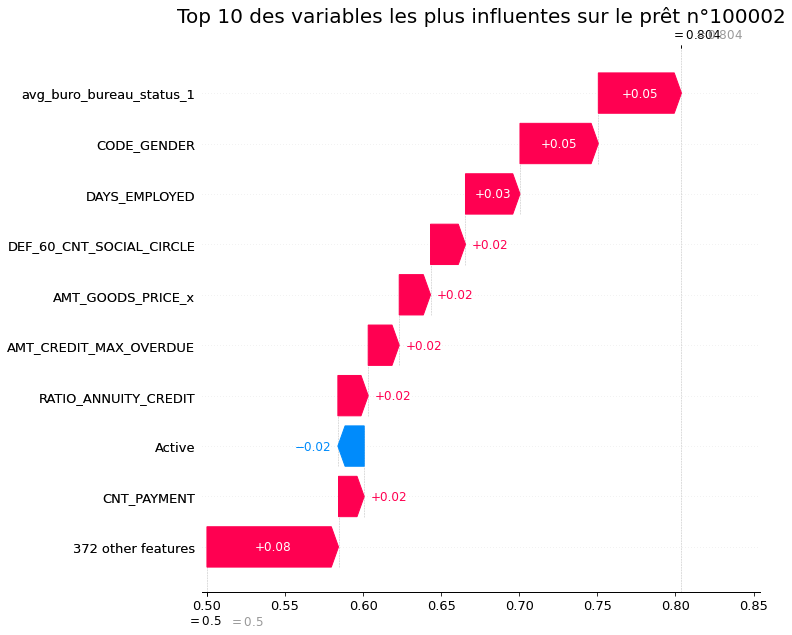

In [139]:
waterfall(str(100002), n_feats=10, shap_data=shap_data)

**Essai de waterfall fait "à la main" plot avec plotly**

In [334]:
def get_shap_values(sk_id):
        #chargement de la table des shap_values
        shap_data = pd.read_csv('shap_data_1000.csv')
        shap_series = shap_data.set_index('Feature')[str(sk_id)]
        return shap_series

In [336]:
def plotly_waterfall(sk_id, n_feats=10):
    
    shap_series = get_shap_values(sk_id)
    shap_series = pd.DataFrame(shap_series)
    shap_series = shap_series.reindex(shap_series[str(sk_id)].abs().sort_values().index)
    shap_series = shap_series[str(sk_id)]

    values = list(shap_series.values*100)
    first_val = sum(values[:(381-n_feats)])
    values = [first_val] + values[381-n_feats:]
    text = [ '%.2f' % elem for elem in values ]
    for i,txt in enumerate(text):
        if float(txt) > 0:
            text[i] = '+' + txt
    text = [txt + ' %' for txt in text]
    ticks = shap_series.index
    ticks = ['Autres'] + list(ticks[381-n_feats:])

    fig = go.Figure(go.Waterfall(
        orientation='h',
        x = values,
        y= ticks, base = 50,
        text = text,
        measure = ["relative" for k in range(len(text)+1)],
        increasing = {"marker":{"color":"red", "line":{"color":"red", "width":2}}},
        decreasing = {"marker":{"color":"green", "line":{"color":"green", "width":2}}}
    ))

    fig.update_layout(title = "Influence de chaque varibale sur la prédiction de difficulté de paiement", waterfallgap = 0.2)
    fig.update_layout(height=int(n_feats*40))
    
    return fig


In [340]:
plotly_waterfall(100004, 20)

# Préparation à l'affichage des statistiques

In [359]:
full_data = pd.read_csv('full_data.csv')
full_data = full_data.set_index('SK_ID_CURR')
full_data = full_data.drop(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)

data = full_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [356]:
data

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,AGE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,RATIO_AGE_WORK_DAYS,RATIO_INCOME_ANNUITY,RATIO_INCOME_CREDIT,RATIO_ANNUITY_CREDIT,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,ca__Active,ca__Baddebt,ca__Closed,ca__Sold,cu__currency1,cu__currency2,cu__currency3,cu__currency4,ty__Anothertypeofloan,ty__Carloan,ty__Cashloannonearmarked,ty__Consumercredit,ty__Creditcard,ty__Interbankcredit,ty__Loanforbusinessdevelopment,ty__Loanforpurchaseofsharesmarginlending,ty__Loanforthepurchaseofequipment,ty__Loanforworkingcapitalreplenishment,ty__Microloan,ty__Mobileoperatorloan,ty__Mortgage,ty__Realestateloan,ty__Unknowntypeofloan,avg_buro_MONTHS_BALANCE,avg_buro_bureau_status_0,avg_buro_bureau_status_1,avg_buro_bureau_status_2,avg_buro_bureau_status_3,avg_buro_bureau_status_4,avg_buro_bureau_status_5,avg_buro_bureau_status_C,avg_buro_bureau_status_X,avg_buro_buro_count,SK_ID_PREV_x,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT_y,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE_y,HOUR_APPR_PROCESS_START_y,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Consumerloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_CONTRACT_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FLAG_LAST_APPL_PER_CONTRACT_N,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CASH_LOAN_PURPOSE_Buildin

In [393]:
sk_id = 100003

In [395]:
round(data.loc[100003].AGE,2)

45.93

In [545]:
import plotly.graph_objects as go

def plot_bar_default(df, var, sk_id, bins=np.array([]), n_bins=10):
    
    value = round(df.loc[sk_id][var],2)
    print(value)
    
    var_data = df[['TARGET', var]]
    min_var, max_var = round(df[var].min(),1), round(df[var].max(),1)
    bin_var = var+'_BINNED'
    
    if bins.any()==False:
        bins = np.linspace(min_var, max_var, num = n_bins)
    
    var_data['var_bin'] = pd.cut(var_data[var], bins = bins)
    var_groups  = var_data.groupby('var_bin').mean()
    var_groups = var_groups.dropna()
    
    
    y = 100 * var_groups['TARGET']
    
    x = var_groups.index.astype(str)
    x = [string.replace(",", " -") for string in x]
    x = [string.replace("(", "") for string in x]
    x = [string.replace("]", "") for string in x]
    
    colors = ['red' for i in range(len(y))]
    i=0
    while value not in var_groups.index[i]:
        i+=1
    colors[i] = 'purple'
    
    fig = go.Figure([go.Bar(x=x, y=y, marker_color=colors)])
    fig.update_layout(title=f'Taux de difficulté de paiement (%) par {var} \
    (Client du prêt n°{sk_id} en violet)')
    
    return fig

In [432]:
var_groups = plot_bar_default(data, 'AGE', 100014, n_bins=10)

In [462]:
data = data[data.CODE_GENDER != 2]

In [463]:
data.to_csv('dashboard_data.csv')

In [457]:
pd.DataFrame(data.apply(pd.Series.nunique, axis = 0).head(381)).T

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,AGE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,RATIO_AGE_WORK_DAYS,RATIO_INCOME_ANNUITY,RATIO_INCOME_CREDIT,RATIO_ANNUITY_CREDIT,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,ca__Active,ca__Baddebt,ca__Closed,ca__Sold,cu__currency1,cu__currency2,cu__currency3,cu__currency4,ty__Anothertypeofloan,ty__Carloan,ty__Cashloannonearmarked,ty__Consumercredit,ty__Creditcard,ty__Interbankcredit,ty__Loanforbusinessdevelopment,ty__Loanforpurchaseofsharesmarginlending,ty__Loanforthepurchaseofequipment,ty__Loanforworkingcapitalreplenishment,ty__Microloan,ty__Mobileoperatorloan,ty__Mortgage,ty__Realestateloan,ty__Unknowntypeofloan,avg_buro_MONTHS_BALANCE,avg_buro_bureau_status_0,avg_buro_bureau_status_1,avg_buro_bureau_status_2,avg_buro_bureau_status_3,avg_buro_bureau_status_4,avg_buro_bureau_status_5,avg_buro_bureau_status_C,avg_buro_bureau_status_X,avg_buro_buro_count,SK_ID_PREV_x,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT_y,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE_y,HOUR_APPR_PROCESS_START_y,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_TYPE_Cashloans,NAME_CONTRACT_TYPE_Consumerloans,NAME_CONTRACT_TYPE_Revolvingloans,NAME_CONTRACT_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FLAG_LAST_APPL_PER_CONTRACT_N,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CASH_LOAN_PURPOSE_Buildin

## Changement du nom des colonnes pour des données plus interprétables

Il faut changer le nom des colonnes de shap_data et de data.

In [487]:
shap_data = pd.read_csv('shap_data_1000.csv')
shap_data = shap_data.set_index('Feature').T

In [524]:
data = pd.read_csv('dashboard_data.csv')
data = data.set_index('SK_ID_CURR')

In [517]:
shap_data = shap_data.rename(columns={'CODE_GENDER': 'Sexe'})
data = data.rename(columns={'CODE_GENDER': 'Sexe'})

In [518]:
data['Sexe'] = data['Sexe'].replace(0, 'Masculin')
data['Sexe'] = data['Sexe'].replace(1, 'Féminin')

In [525]:
def plot_bars(df, var, sk_id):

    default_tab = df[df.TARGET==1].groupby(var)['TARGET'].count()
    total_tab = df.groupby(var)['TARGET'].count()

    ind = total_tab.index
    default = []
    
    for i, index in enumerate(total_tab.index):
        default.append(default_tab[index]/total_tab[index]*100)
     
    colors=['red', 'red']
    value = df.loc[sk_id][var]
    i=0
    while value != total_tab.index[i]:
        i+=1
    colors[i] = 'purple'
            
    fig = go.Figure([go.Bar(x=ind, y=default, marker_color=colors)])
    fig.update_layout(title=f'Taux de difficulté de paiement (%) par {var} \
    (Client du prêt n°{sk_id} en violet)')
    
    return fig, value

In [551]:
plot_bars(data, 'Sexe', 100007)